### 필요 라이브러리 import

In [20]:
# %pip install -r requirements.txt

In [21]:
# Cartpole 게임 rendering을 위한 라이브러리
%pip install gym
%pip install gymnasium
%pip install gymnasium[classic_control]
%pip install numpy
%pip install tensorflow
%pip install tensorflow_probability
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [22]:
import gymnasium as gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

from tensorflow import keras
import tensorflow_probability as tfp

## Background

### Q-Learning과의 차이점

#### Q-Learning 특징

Q-Learning 기법은 각 state가 지니는 가치(value)를 테이블로 저장하고, 이 테이블을 기반으로 누적가치가 가장 큰 action을 순차적으로 결정한다.
Q-Learning은 모든 state들을 테이블로 관리하기에 근본적인 문제가 존재한다.
 - 상태의 수가 매우 많거나 무한에 가까울 경우 테이블 형성이 어렵다.
 - 마찬가지로, 상태의 수가 너무 많으면 모든 상태를 방문해야 하는 Q-learning의 특성이 현실적으로 불가능하게 만든다.

![policy](assets/pg_4.png?raw=true)


#### Policy Gradient 특징

Policy Gradient 기법은 이와 다르다. Q-Learning은 각 state에서 취한 action이 지니는 가치를 평가하는 "행동 가치 함수", 즉 에이전트가 취하는 행동에 대한 평가를 진행하는 행동-가치 함수를 이용한다.

하지만 Policy Gradient는 이와달리 주어진 상태에서 어떤 행동을 취할지를 알려주는 일종의 행동지침서(policy)를 작성하는 과정이다. 일반적으로는, Policy Gradient의 정책 π는 주어진 상태 s∈S에서 어떤 행동 a∈A을 선택할 조건부 확률이다.

![policy](assets/pg_5.png?raw=true)


아래 그림처럼, 결국 Q-Learning과 Policy Gradient의 차이점은 state을 입력받아 action을 결정하는 방법을 Q-Table에서 함수 기능을 하는 신경망 정책 Policy로 변환한 것이다.

![policy](assets/pg_2.png?raw=true)

### Policy Gradient 개요
 - 강화학습 기법 중 하나인 Policy Gradient는 현재 상황 state s가 주어졌을때, 특정 action a를 취할 확률을 계산하는 "함수"인 policy를 업데이트하는 방법이다.

    $$ \vdots $$

    이때 이 policy를 π로, policy의 파라미터를 θ로 기술한다. 
    예를 들어 πθ(a|s)는 state s가 주어졌을 때 action a를 취할 확률을 뜻한다. 

    policy gradient에선 neural network를 policy로 정의하기에, 파라미터 θ는 곧 신경망 π의 파라미터인 가중치(wight), 편향(bias)로 구성된다.
    따라서 policy의 정의는 state 학률분포를 입력받아 action 확률분포를 출력하는 신경망으로, 위처럼 πθ(a|s)로 표현할수 있다.


    policy gradient의 최종 목표는 정책함수 J(θ)는 아래처럼 누적보상의 기댓값이 최대화되는 것이기에, gradient ascent를 사용하여 θ를 업데이트 하여 πθ를 최적화하는 것을 목표로 한다.

    $$J(\theta) =  \mathbb{E}_{\tau \sim \pi_\theta} \left[ R_{(\tau)} \right]$$
   
    $$ = \sum_{s\in S} d(s) \sum_{a \in A} \pi(s,a)R_{(s,a)} $$

    정책 퍼포먼스(기대수익)의 기울기(gradient of policy performence)는 Policy Gradient라고 불리고, 이를 수식으로 나타내면

   $$\theta^{'} \leftarrow \theta + \alpha \nabla_{\theta} J(\theta)$$
   
   $$\nabla_{\theta} J(\theta) = \frac{\partial J(\theta)}{\partial \theta}$$    

   $$ \nabla_{\theta}J{\theta} = \sum_{s\in S} d(s) \sum_{a \in A} \pi_{\theta}(s,a) \nabla_{\theta} \log \pi_{\theta}(s,a) R_{(s,a)} $$

   $$ = \mathbb{E}[\nabla_{\theta}\log \pi_{\theta}(s,a) R_{(s,a)}] $$

   이다. 최종적으로 구해진 수식은 특정 상태에서 시작할 확률 d(s)와 특정상태에서 특정 행동을 고를 확률 πθ(a|s)를 고려한 $$ \nabla\log\pi_{\theta}(s,a)*R_{\pi}(s,a) $$ 의 가중합을 의미한다.
   이때 log함수가 나오며 전개된 이유는,

   $$ \frac{d(\log x)}{dx} = \frac{1}{x} $$
   $$ \frac{d(\log f(x))}{dx} = \frac{f^{'}(x)}{f(x)} $$

   $$ \nabla_{\theta} \pi_{\theta}(s,a) = \pi_{\theta}(s,a) \frac{\nabla_{\theta}\pi_{\theta}(s,a)}{\pi_{\theta}(s,a)} $$
   $$ = \pi_{\theta}(s,a) \nabla \log \pi_{\theta}(s,a) $$ 
   
   이기 때문이다.



![policy](assets/pg_3.png?raw=true)

다시 돌아와서, policy gradient의 최종 목적은 목적함수 J(θ)의 누적 보상을 최대화 하는 것이다. 

이를 위해 위에서 전개된 식과 위의 그림을 참고해보면, 최종적으로 전개된 식

$$ \mathbb{E}[\nabla_{\theta}\log \pi_{\theta}(s,a) R_{(s,a)}] $$

에서 알수 있듯이, policy에서 state의 입력으로 나온 action 확률 분포에 log 함수를 씌운것과, 해당 action에 대한 보상들을 곱하여 가중합한 것이다.

#### 강화학습 환경 설명

- 사용 라이브러리 및 게임 : gym, Cartpole-v1

- 게임 설명 : 마찰이 없는 트랙에 카트가 존재하고, 카트에는 위로 길다란 막대가 연결되어 있어 카트를 좌우 이동시키며 막대가 한쪽으로 쓰러지지 않도록 컨트롤한다. 일정 각도 이상(-12, +12)으로 기울어지면 패배하므로 카트를 이동시켜 최대한 오랫동안 막대를 지지하여 쓰러뜨리지 않는 게임이다.

     해당 게임은 카트가 중심으로부터 너무 벗어나 게임 화면 밖으로 나갈 경우 종료되고, 막대를 쓰러뜨릴 경우에도 종료되며 연속 500 time step 동안 막대를 잘 세워 누적보상 500에 달성할 경우에도 게임이 종료된다.

![policy](assets/cartpole.png?raw=true)



> 주요 파라미터
- State
     : Cartpole 게임 환경의 상태. 막대와 카트의 위치 및 속도 정보를 포함하는 [1X4] 크기의 numpy 배열이다.
- Action
     : 카트 에이전트가 선택한 카트의 이동방향. 0이면 좌측, 1이면 우측으로 이동한다.
- Rewards
     : 카트 에이전트가 취한 행동에 대한 보상이다. 1 step마다 게임이 잘 진행되고 있다면 1의 보상이 주어지기에, 에피소드 마다 이를 누적하여 누적보상이 얼마나 큰지를 비교하며 카트 에이전트가 게임을 오랫동안 진행했는지 여부를 판단할 수 있다. 

#### Cartpole 게임 주요 코드


1. 환경세팅
 - env = gym.make("CartPole-v1")  -> # 게임환경 env 생성
 - env = gym.make("CartPole-v1", render_mode='human')  -> # 게임환경 env 생성. 창을 띄워 게임현향을 rendering합니다.

2. 환경초기화
 - state = env.reset()[0]  -> # 게임을 초기화하여 특정 초기 상태로 되돌린다. 이때 state가 리턴되어 다음 행동 결정에 사용됩니다.

3. 게임 1step 진행
 - new_state, reward, term, trunc, _ = env.step(action)  -> # 결정한 action(0 혹은 1의 int값)을 입력하여 카트의 움직임을 결정합니다. 카트가 움직여 게임이 진행되면 새로운 state와 그에 따른 보상(0. 혹은 1.의 float 값)을 리턴받습니다.

## 구현 Code

#### Dense레이어 및 전체 신경망 모듈 생성

In [23]:
# 텐서플로 버전으로 제작한 Fully Connected Layer다.
class Dense(tf.Module):
    def __init__(self, in_features, out_features, activations=True):
        super().__init__()
        # Dense 레이어는 입력사이즈 in_features와 출력 사이즈 out_features를 받아 해당 사이즈에 맞게 가중치와 편향 변수를 가진다.
        # weight는 정규분포확률을 따르는 랜덤값으로, [in_feature, out_features]의 크기를 가지며,
        # bias는 초기값 0의 배열로 [out_features, ]의 크기를 지닌다.
        self.weight = tf.Variable(tf.random.normal(shape=[in_features, out_features], 
                                                   mean=0.0, stddev=0.25, dtype=tf.float32))
        self.bias = tf.Variable(tf.zeros([out_features], dtype=tf.float32))

        # 출력층에 위치한 레이어인지 구분하기 위한 flag다.
        # 히든 레이어의 Dense라면 True를 주어 활성화 함수로 ReLU를 선택하고,
        # 출력 레이어의 Dense라면 False를 주어 활성화 함수로 softmax를 주어 최종적인 action의 합이 1인 확률 분포를 출력해주도록 한다.
        self.activations = activations

    def __call__(self, x):
        # z = wX + b를 진행후, 화성화 함수를 거쳐 다음 레이어로 결과를 전달한다.
        z = tf.matmul(x, self.weight) + self.bias
        if self.activations:
            return tf.nn.relu(z)
        return tf.nn.softmax(z)

# Fully Connected Layer로 이루어져 Linear Classification을 진행하는 신경망 모델이다.
# 위에서 제작한 Dense 레이어를 조합하여 4, 256, 256, 2 의 노드를 가지는 신경망 구조를 지닌다.
class SequentialModule(tf.Module):
    def __init__(self, input_size, hidden_size, output_size, name="SequentialModule"):
        super().__init__(name=name)
        self.dense_1 = Dense(in_features=input_size, out_features=hidden_size)
        self.dense_2 = Dense(in_features=hidden_size, out_features=hidden_size)
        self.dense_3 = Dense(in_features=hidden_size, out_features=output_size, activations=False)

    def __call__(self, x):
        # 모델의 순전파 과정.
        x = self.dense_1(x)
        x = self.dense_2(x)
        logits = self.dense_3(x)
        return logits

In [24]:
# 학습을 진행하는 Agent.
class Agent:
    def __init__(self, alpha=0.001, gamma=0.99, n_actions=2, n_obs=4,
                 neurons1=256, neurons2=256):
        # 에피소드가 끝났을때 획득한 누적 보상을 구할때 적용하는 discount factor 역할을 하는 감마다.
        # 미래의 보상일 수록 discount factor가 크게 적용되어 과거, 현재의 보상에 더 큰 가중치를 두도록 한다.
        self.gamma = gamma
        # action의 개수. Cartpole 게임에선 0(Left)과 1(right)뿐이므로 2가 저장된다.
        self.n_actions = n_actions

        # 한 에피소드 내에서 누적되는 연속적인 state, action, reward 들을 저장하는 버퍼 역할의 배열들이다.
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []

        # 매 에피소드 마다 누적보상의 합을 기록하고, 이에 대한 20일 평균 이동선을 그리기 위한 배열들
        self.score_history = []
        self.avg_history = []

        # 모델 및 Adam 옵티마이저 설정. 학습률은 에이전트 생성 인자로 받은 alpha로 적용하였다.
        self.policy = SequentialModule(n_obs, neurons1, n_actions)
        self.opt = tf.optimizers.Adam(learning_rate=alpha)
        
    def choose_action(self, observation):
        # 주어진 state에 대해서 actions 확률을 추론하고, 
        # 이 actions에 대해서 확률분포를 취한 뒤에 "확률분포에 따른" 랜덤샘플링을 진행한다.
        # 이는 현재 상태에서 right 방향으로 이동하는 확률이 매우 높다면, actions 확률 분포의 랜덤 샘플링 결과에서 right가 나올 확률이 높아지는 것을 의미한다.
        state = tf.convert_to_tensor([observation], dtype=tf.float32)
        # 현재 state를 입력으로 받아 취할 행동 확률 분포를 받는 probs.
        probs = self.policy(state)
        # action 확률분포에서 확률분포에 의거한 샘플링을 진행한다.
        distribuition_actions = tfp.distributions.Categorical(probs=probs)
        action_choosed = distribuition_actions.sample()
        # 최종적으로 에이전트가 취해야할 샘플링된 action을 리턴해준다.
        return action_choosed.numpy()[0]

    def store_transition(self, observation, action, reward):
        # 한 에피소드에서 1 time step을 진할할때마다 state, action, reward를 저장해준다.
        self.state_memory.append(observation)
        self.action_memory.append(action)
        self.reward_memory.append(reward)
    
    def learn(self):
        actions = tf.convert_to_tensor(self.action_memory, dtype=tf.float32)
        reward = tf.convert_to_tensor(self.reward_memory, dtype=tf.float32)
        
        # reward를 누적시키며 state 순서의 누적 보상 배열을 생성한다.
        # 누적 보상은 state가 진전될 수록(미래의 state일 수록) discount factor인 gamma의 영향을 더욱 받게 되어
        # 미래의 보상은 보다 작은 영향을 끼치게 된다.
        cum_rewards = np.zeros_like(reward)
        reward_len = len(reward)
        for j in reversed(range(reward_len)):
            cum_rewards[j] = reward[j] + (cum_rewards[j+1]*self.gamma if j+1 < reward_len else 0)

        # with tf.GradientTape() as tape는 연산되는 과정을 미분하며 backward할수 있는 기능이다.
        # 앞서 정의했던대로, 최종적으로 구하려는 score function의 gradient는
        # 1. log(현재 state를 입력으로 받아 출력된 신경망의 action 확률분포)
        # 2. 해당 action 확률 분포에 따른 행동을 취했을때의 reward
        # 이 두 요소를 곱해주고, 이에 대한 기댓값이 최종적으로 구하려는 dJ (score function의 gradient)다.
        # with tf.GradientTape() as tape:
            # loss = 0
            # for idx, (g, state) in enumerate(zip(cum_rewards, self.state_memory)):
            #     state = tf.convert_to_tensor([state], dtype=tf.float32)
            #     probs = self.policy(state)
            #     action_probs = tfp.distributions.Categorical(probs=probs)
            #     log_prob = action_probs.log_prob(actions[idx])
            #     loss += - g * tf.squeeze(log_prob)

        # 위 코드는 for문으로 순차적으로 state를 순회하며 각 state에서의 loss 기댓값을 누적하는 코드다.
        # 굳이 for문을 이용하지 않고도, 아래처럼고차원 매트릭스의 장점을 이용하여 한번에 계산하여 학습시간을 단축시켰다.
        with tf.GradientTape() as tape:
            state = tf.convert_to_tensor(self.state_memory, dtype=tf.float32)
            
            # 각 state들을 입력으로 주어, 각 상황에 취해야할 action 확률 분포를 리턴받는다.
            probs = self.policy(state)
            # action 확률 분포에 대하여 log를 취한다.
            log_prob = tfp.distributions.Categorical(probs=probs).log_prob(actions)
            # {- log(현재 state를 입력으로 받아 출력된 신경망의 action 확률분포) * 해당 action 확률 분포에 따른 행동을 취했을때의 reward} 를 계산하여 최종적인 dJ, loss를 계산한다.
            loss = - cum_rewards * tf.squeeze(log_prob)
            # 계산된 loss를 기반으로 연산에 참여했던 에이전트의 파라미터들 각각의 gradient를 구해준다.
            gradient = tape.gradient(loss, self.policy.trainable_variables)

            # 각 gradient값들을 이용하여 최적화 진행.
            self.opt.apply_gradients(zip(gradient, self.policy.trainable_variables))

        # 스코어 합을 저장하고, 최근 20 에피소드간의 스코어 합 평균을 리스트에 저장하여 학습의 진전을 확인하는 용도
        self.score_history.append(sum(self.reward_memory))
        self.avg_history.append(np.mean(self.score_history[-20:]))

        # 한 에피소드가 끝나면 기존의 state, action, reward 리스트를 비워버린다.
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []
    
    # 매개변수 last_count번 연속으로 최근 score가 최고 보상인 500.0을 넘었을 경우, 학습을 조기에 종료하는 Early stopping이다.
    def early_stopping(self, last_count):
        last_score = np.array(self.avg_history[-last_count:])
        # last_score 배열에서 마지막 last_count개만 뽑아서 해당 score가 500.0점 이상인 경우만 bool indexing하여 이들의 개수를 카운트 했다.
        if np.count_nonzero(last_score[last_score >= 500.0]) >= last_count:
            print("Early Stopping....")
            return True
        return False

    # 사전에 학습 완료된 모델의 파라미터 정보를 불러와서 에이전트에 재저장.
    def load_model(self, path):
        checkpoint = tf.train.Checkpoint(self.policy)
        checkpoint.restore(f'{path}-1')

    # 현재 에이전트가 가진 파라미터 정보를 체크포인트로 저장한다.
    def save_model(self, path):
        checkpoint = tf.train.Checkpoint(self.policy)
        save_path = checkpoint.save(path)
        print(save_path)
        

In [25]:
# 에이전트 생성. 학습률과 discount factor gamma를 인자로 주어야 하며, 입력 사이즈와 출력 사이즈가 각각 4, 2이다.
agent = Agent(alpha=0.0005, gamma=0.99, n_actions=2, n_obs=4)
# 에피소드 수 만큼 반복하며 에이전트 학습.
episodes = 1000

# 학습을 진행하지 않고, 바로 완성된 모델을 불러와 게임 진행을 보고 싶으시다면 아래 test 변수를 True로 바꿔주시면 됩니다.
# 전체적인 학습 과정을 지켜보시려면 test 변수를 False로 바꿔주시고 실행시키시면 학습이 진행됩니다. (보다 빠른 학습을 위해 rendering 화면 없이 학습됩니다.)
# test = False
test = True


## ===============================================================================================
if test:
    # 완성된 모델을 불러와 게임환경을 rendering하며 진행 확인
    agent.load_model('./checkpoints/best_model')
    env = gym.make("CartPole-v1", render_mode='human')
    for i in range(episodes):
        done = False
        score = 0
        # 매 에피소드마다 게임 환경, 세팅 초기화
        state = env.reset()[0]
        # 매 에피소드마다 게임이 끝날때까지 action을 계속한다.
        while not done:
            # 현재 상태를 입력받아 agent 모델이 action 확률분포에 의거한 랜덤샘플링의 결과로 최종적인 action을 결정한다.
            action = agent.choose_action(state)
            # 결정된 action으로 게임을 1 step 진행하고, 이에 대해 새로운 state와 이에 대한 보상, 종료 여부를 받는다.
            new_state, reward, term, trunc, _ = env.step(action)

            # 카트가 누적보상 500점에 달성했거나, 막대가 12도 이상 기울거나 혹은 화면 밖으로 나갔을 경우 에피소드를 종료한다.
            done = term or trunc
            # 현재 state, 그에 따라 취한 action, 그에 따라 받은 reward 기록을 에이전트의 버퍼에 저장.
            agent.store_transition(state, action, reward)
            # state를 새로운 state로 바꿔준다.
            state = new_state
            # 한 에피소드 동안 누적되는 보상인 score.
            score += reward

        # 한 에피소드가 종료되어, 그간 에이전트의 버퍼에 기록된 state, action, reward 기록을 기반으로 에이전트의 policy를 학습시킨다.
        agent.learn()
        print(f'Episode: {i} // Score: {agent.avg_history[-1]}', end="\r")
        # 에피소드별 학습 결과로, 누적스코어가 최고 보상인 500.0을 연속 5번 초과하는 경우, 
        # policy가 충분히 학습되었다 판단하여 학습을 중지시킨다.
        if agent.early_stopping(5):
            break
else:
    # 새로운 모델을 학습시키는 과정. 학습되는 과정을 rendering하여 시각적으로 확인하며 진행이 가능하나, 
    # 학습시간이 너무 오래걸려서 학습 모드에서는 게임창을 rendering하지 않았다.
    # env = gym.make("CartPole-v1", render_mode='human')
    env = gym.make("CartPole-v1")
    for i in range(episodes):
        done = False
        score = 0
        # 매 에피소드마다 게임 환경, 세팅 초기화
        state = env.reset()[0]
        # 매 에피소드마다 게임이 끝날때까지 action을 계속한다.
        while not done:
            # 현재 상태를 입력받아 agent 모델이 action 확률분포에 의거한 랜덤샘플링의 결과로 최종적인 action을 결정한다.
            action = agent.choose_action(state)
            # 결정된 action으로 게임을 1 step 진행하고, 이에 대해 새로운 state와 이에 대한 보상, 종료 여부를 받는다.
            new_state, reward, term, trunc, _ = env.step(action)

            # 카트가 누적보상 500점에 달성했거나, 막대가 12도 이상 기울거나 혹은 화면 밖으로 나갔을 경우 에피소드를 종료한다.
            done = term or trunc
            # 현재 state, 그에 따라 취한 action, 그에 따라 받은 reward 기록을 에이전트의 버퍼에 저장.
            agent.store_transition(state, action, reward)
            # state를 새로운 state로 바꿔준다.
            state = new_state
            # 한 에피소드 동안 누적되는 보상인 score.
            score += reward
        
        # 한 에피소드가 종료되어, 그간 에이전트의 버퍼에 기록된 state, action, reward 기록을 기반으로 에이전트의 policy를 학습시킨다.
        agent.learn()
        print(f'Episode: {i} // Score: {agent.avg_history[-1]}', end="\r")
        # 에피소드별 학습 결과로, 누적스코어가 최고 보상인 500.0을 연속 5번 초과하는 경우, 
        # policy가 충분히 학습되었다 판단하여 학습을 중지시킨다.
        if agent.early_stopping(5):
            break

    # 학습이 완료된 모델의 파라미터 정보 저장
    agent.save_model('./checkpoints/best_model')

    # 학습이 완료되어, 해당 에이전트가 게임을 잘 진행하는지 rendering하여 확인.
    # 아래 코드는 위의 에피소드 진행 코드와 동일하여 설명 생략.
    env = gym.make("CartPole-v1", render_mode='human')
    for i in range(episodes):
        done = False
        score = 0
        state = env.reset()[0]
        while not done:
            action = agent.choose_action(state)
            new_state, reward, term, trunc, _ = env.step(action)
            done = term or trunc
            agent.store_transition(state, action, reward)
            state = new_state
            score += reward

        agent.learn()
        print(f'Episode: {i} // Score: {agent.avg_history[-1]}', end="\r")
        if agent.early_stopping(5):
            break

KeyboardInterrupt: 

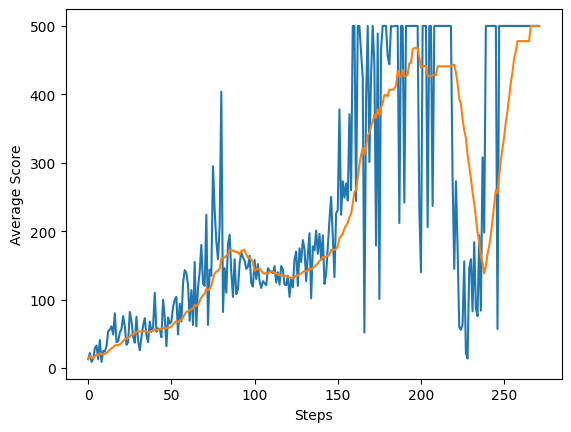

In [ ]:
plt.plot(list(range(len(agent.score_history))), agent.score_history)
plt.plot(list(range(len(agent.avg_history))), agent.avg_history)
plt.xlabel('Steps')
plt.ylabel('Average Score')
plt.show()